In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from PIL import Image
import glob
import shutil

# unnest all cases get images data, rank by survival days, select top 1000 and bottom 1000

In [2]:
nested_data = pd.read_csv('/A_LUAD/project/final_project/data/case_info.csv')

In [3]:
image_index = []
for i in nested_data['image_num']:
  temp = list(range(1,i+1))
  image_index.append(temp)
print(image_index)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 2

In [4]:
nested_data['image_index'] = image_index

In [5]:
unnested_data = nested_data.explode('image_index')

In [6]:
unnested_data['image_id'] = unnested_data['case_submitter_id'] + '_' + unnested_data['image_index'].astype(str)

In [7]:
cleaned_unnested_data=unnested_data.drop(columns=['image_num','image_index'])
cleaned_unnested_data=cleaned_unnested_data[['image_id','case_submitter_id','vital_status','survival_days','survival_year','group','ajcc_pathologic_stage','ajcc_staging_system_edition','ajcc_pathologic_t','ajcc_pathologic_m','ajcc_pathologic_n','primary_diagnosis']]

In [8]:
cleaned_unnested_data.to_csv('/A_LUAD/project/final_project/data/images_info.csv', index=False)

# resize image data and generate SOM_data

In [9]:
from PIL import Image, ImageOps
import glob


In [10]:
size = 90
dic = dict()

In [11]:
# read csv files, get all information
image_paths = glob.glob("D:/A_LUAD/project/final_project/data/raw_data/*.png")
print("Total Observations:\t", len(image_paths))

Total Observations:	 4726


In [12]:
data = pd.read_csv('/A_LUAD/project/final_project/data/extreme_images_info.csv')
all_images_path = ['D:/A_LUAD/project/final_project/data/raw_data/{}.png'.format(i) for i in data['image_id'].values]

In [13]:
all_images_path[1].split('/')[-1][:-4]

'TCGA-78-8640_2'

In [14]:
igname = all_images_path[1].split('/')[-1]
ig = Image.open(all_images_path[1])
ig_resize = ig.resize((size,size))
ig_gray = ImageOps.grayscale(ig_resize)

In [15]:
pix = np.array(ig_gray)
pixs = pix.flatten()
pixs = pixs.tolist()
dic[igname] = pixs

In [16]:
matrix = []
ids = []
for i in all_images_path:
  igname = i.split('/')[-1][:-4]
  ig = Image.open(i)
  ig_resize = ig.resize((size,size))
  ig_gray = ImageOps.grayscale(ig_resize)
  pix = np.array(ig_gray)
  pixs = pix.flatten()
  matrix.append(pixs.tolist())
  ids.append(igname)
matrix = np.array(matrix).T  

In [17]:
id_col = {'image_id':ids}
SOM_data = pd.DataFrame(id_col)
pix_idx = 0
for col in matrix:
  key = 'pix'+str(pix_idx)
  SOM_data[key] = col
  pix_idx+=1

C:\Users\ZZY\.conda\envs\tfcuda11.2\lib\site-packages\ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [18]:
labels = data[['image_id','group']]

In [19]:
# SOM_data.join(labels.set_index('image_id'), on='image_id')
SOM_data = SOM_data.merge(labels, how='inner', on='image_id')

# SOM

In [20]:
from minisom import MiniSom
import os

In [21]:
som_data = SOM_data.drop(columns=['image_id','group']).values

In [22]:
labels  = SOM_data['group'].values

In [23]:
target = labels
label_names = {1:'low_risk', 2:'high_risk'}
data = som_data
# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

In [24]:
n_neurons = 20
m_neurons = 20
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)

som.pca_weights_init(data)
som.train(data, 50000, verbose=True)  # random training

C:\Users\ZZY\.conda\envs\tfcuda11.2\lib\site-packages\minisom.py:379: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 57.139312659589834


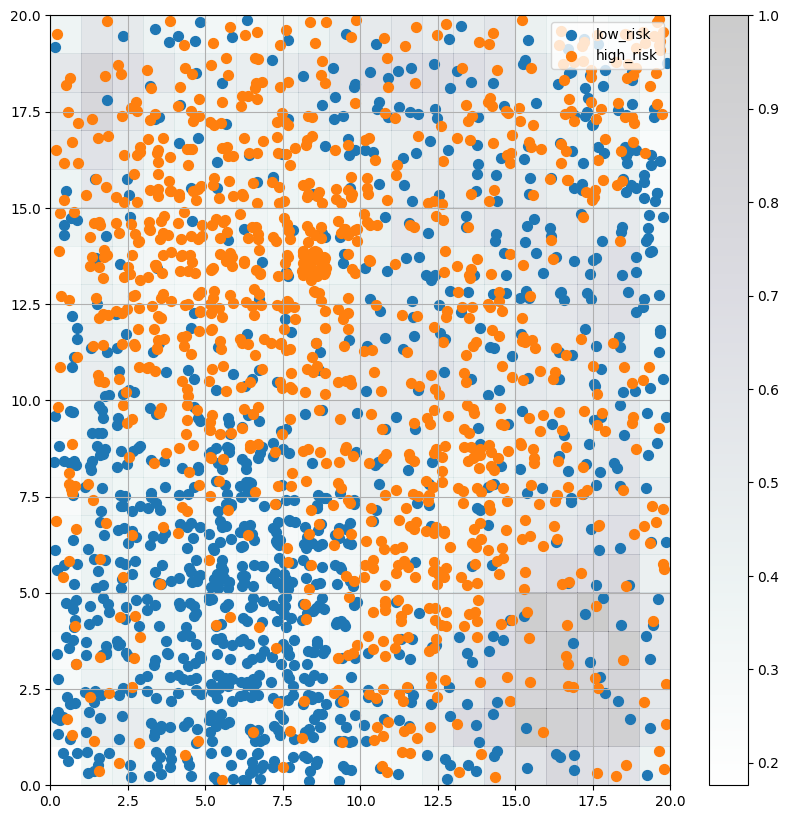

In [27]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
figname='50000_'+str(size)+'_cluster.png'
result = '/A_LUAD/project/final_project/cluster_results'
plt.savefig(os.path.join(result,figname))
plt.show()

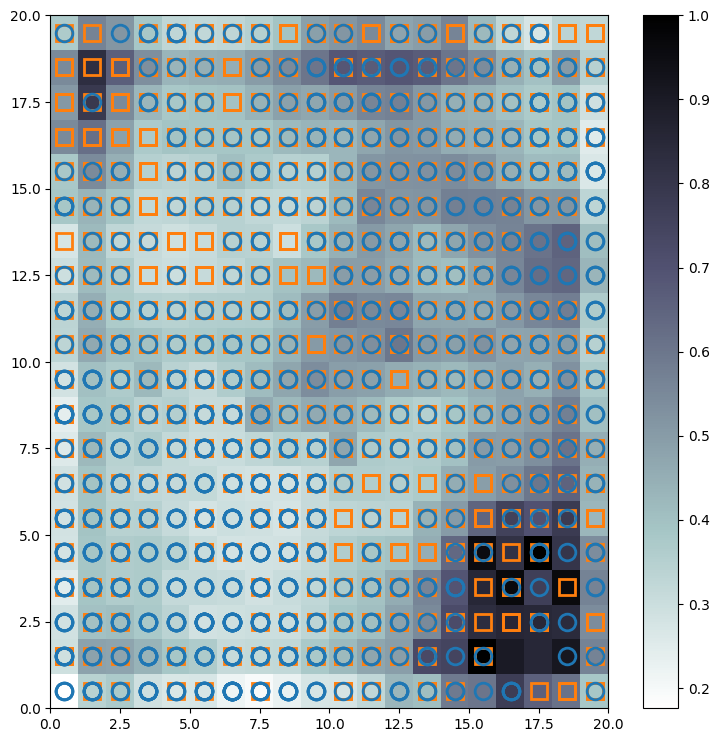

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

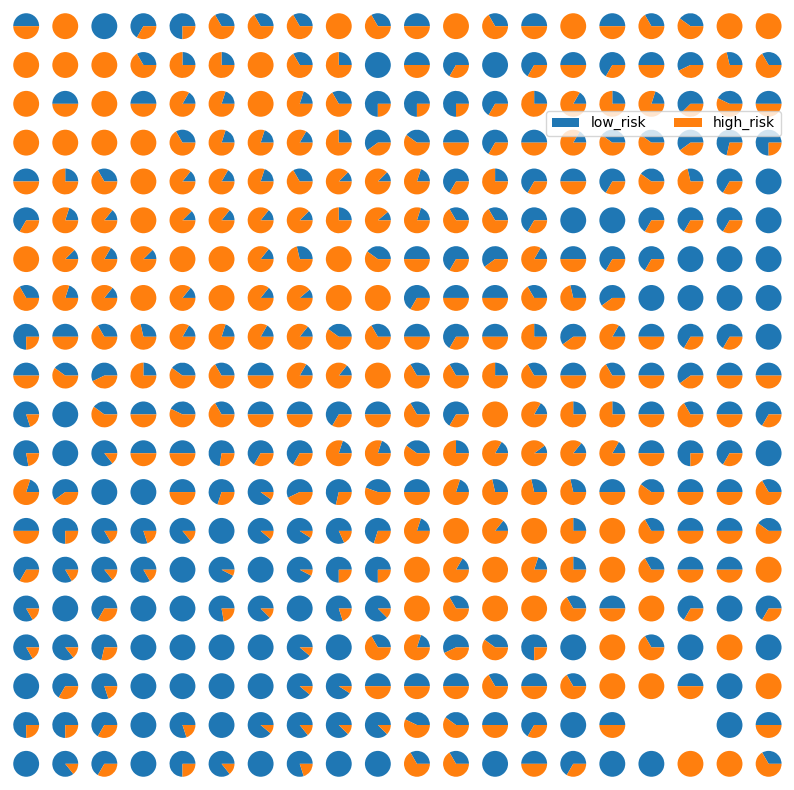

In [28]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(data, [label_names[t] for t in target])

fig = plt.figure(figsize=(10, 10))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
figname='50000_'+str(size)+'_cluster_2.png'
result = '/A_LUAD/project/final_project/cluster_results'
plt.savefig(os.path.join(result,figname))
plt.show()